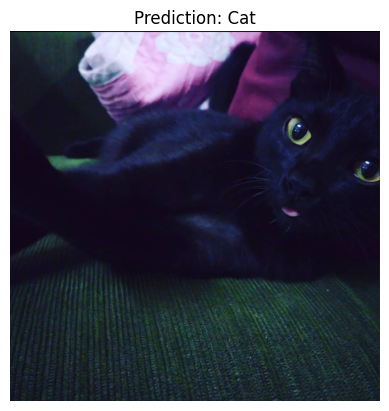

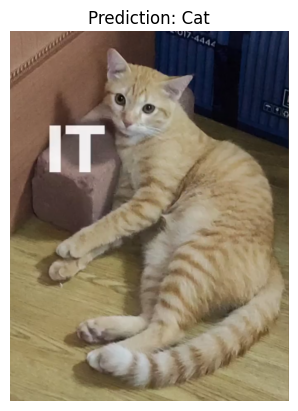

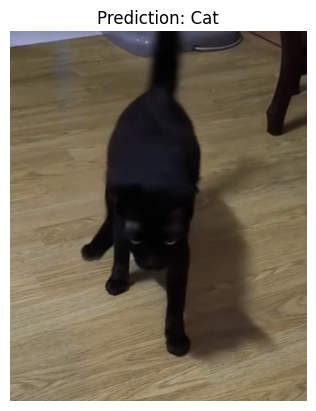

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os  # ใช้สำหรับจัดการไฟล์ในโฟลเดอร์

# โครงสร้างโมเดล
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        # สมมติว่าใช้ Convolutional Layer
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        # ใช้ Linear Layer
        self.fc = nn.Linear(16 * 112 * 112, 2)  # ปรับขนาดให้ตรงตาม output ของ Conv layer

    def forward(self, x):
        # ผ่าน Convolutional Layer
        x = self.pool(F.relu(self.conv1(x)))  # Apply ReLU and Pooling
        
        # Flatten ข้อมูลก่อนที่เข้า Linear Layer
        x = x.view(-1, 16 * 112 * 112)  # Flatten ให้เป็น (batch_size, features)
        
        # ผ่าน Linear Layer
        x = self.fc(x)
        return x

# ฟังก์ชันสำหรับทำนายรูปหมา/แมว
def predict_image(image_path, model):
    # โหลดรูปภาพและแปลงเป็น RGB (ถ้ารูปภาพมี 4 ช่องทาง เช่น RGBA)
    image = Image.open(image_path).convert('RGB')
    
    # กำหนดการแปลงรูปภาพให้เหมาะสมกับโมเดล
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # แปลงรูปภาพ
    image_tensor = transform(image).unsqueeze(0)  # เพิ่ม batch dimension (1, C, H, W)
    
    # ตรวจสอบว่าใช้ GPU หรือ CPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    image_tensor = image_tensor.to(device)

    # ทำการทำนาย
    model.eval()  # ตั้งค่าโมเดลเป็นโหมดทำนาย
    with torch.no_grad():  # ปิดการคำนวณ gradients
        outputs = model(image_tensor)  # ทำนายจากโมเดล
    
    # แปลงผลลัพธ์ให้เป็น label (ถ้าใช้ Binary Classification: หมาหรือแมว)
    _, predicted = torch.max(outputs, 1)
    
    if predicted.item() == 0:
        return "Cat", image  # ส่งคืนทั้งผลลัพธ์และภาพ
    else:
        return "Dog", image  # ส่งคืนทั้งผลลัพธ์และภาพ

# โหลดโมเดลทั้งหมดจากไฟล์ โดยใช้ weights_only=False เพื่อโหลดทั้งโครงสร้างและน้ำหนัก
model = torch.load("full_model.pth", map_location=torch.device('cpu'), weights_only=False)

# กำหนดโฟลเดอร์ที่เก็บรูปภาพ
folder_path = "."  # ใช้ "." เพื่อหมายถึงโฟลเดอร์ปัจจุบัน

# หาทุกรูปในโฟลเดอร์ที่มีนามสกุล .png, .jpg หรือ .jpeg
image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

# ทำนายผลสำหรับทุกไฟล์ในโฟลเดอร์
for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)
    result, image = predict_image(image_path, model)  # ทำนาย
    
    # แสดงรูปภาพและผลลัพธ์
    plt.imshow(image)
    plt.title(f"Prediction: {result}")
    plt.axis('off')  # ปิดการแสดงแกน
    plt.show()
